# Week 7
## Overview

This week's curriculum focuses in figuring out (and visualizing) what's special about a certain text (or collection of texts). We'll also learn about community detection in networks (that's how we'll get our groups of text)

* Tricks for raw text (NLPP, Chapter 3).
* Community Detection and info-boxes 
* Identifying important words in a document (TF-IDF)

In the first part, we will take a quick tour of NLPP1e's chapter 3, which is boring, super useful ressource. Then we'll talk about how we can use simple statistics & machine learning to get text to show us what it's all about. We will even do a little visualization. 

In the latter parts we will go back to network science, discussing community detection, mixing in some NLP, and trying it all out on our very own dataset.


# Part 1: Processing real text (from out on the inter-webs)

Ok. So Chapter 3 in NLPP is all about working with text from the real world. Getting text from this internet, cleaning it, tokenizing, modifying (e.g. stemming, converting to lower case, etc) to get the text in shape to work with the NLTK tools you've already learned about - and many more. 

In the process we'll learn more about regular expressions, as well as unicode; something we've already been struggling with a little bit will now be explained in more detail. 

<div class="alert alert-block alert-info">
One of the things that the LLMs have changed is how we don't have to suffer over regular expressions as much as in the old days. As I talk about in the video, regular expressions used to be a big, painful part of working with text. Nowadays, we can simply ask an LLM to help construct them ... and it tends to work really well. And regular expressions are not really important to know about - you need to know they exist so you can used them, but the details are not worth remembering. So this is one area where you can use LLMs as much as you like without a guilty conscience. (But remember to check and test the results thoroughly! The LLMs might still make mistakes.)
</div>

> 
> **Video lecture**: Short overview of chapter 3 + a few words about kinds of language processing that we don't address in this class. 
> 

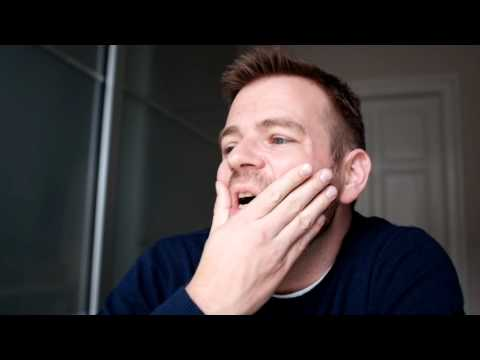

In [2]:
from IPython.display import YouTubeVideo
from networkx.algorithms.assortativity.pairs import node_degree_xy

from exercises.Week5 import rock_artists_graph

YouTubeVideo("Rwakh-HXPJk",width=800, height=450)

> *Reading*: NLPP Chapter 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.9, and 3.10\. It's not important that you go in depth with everything here - the key think is that you *know that Chapter 3 of this book exists*, and that it's a great place to return to if you're ever in need of an explanation of regular expressions, unicode, or other topics that you forget as soon as you stop using them (and don't worry, I forget about those things too).
> 

# Part 2: Community detection

Let's begin by watching a lecture to learn about communities. If you want all the details, I recommend you take a look at _Chapter 9_ in the _Network Science_ book ... but the video lecture below should be enough to get you started. 

**Note**: For this and the next exercise, work on the _undirected_ version of the network.

> **_Video Lecture_**: Communities in networks.

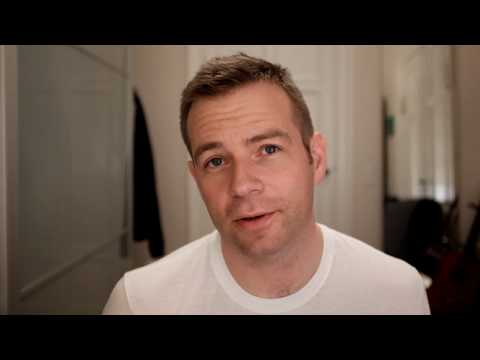

In [3]:
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

# direct youtube link: https://www.youtube.com/watch?v=FSRoqXw28RI

eBefore we get started on *network* communities, we'll grab some information on a different kind of communities based on information from Wikipedia. Specifically, the ``infoboxes``. An infobox is the little box usually displayed on the right when you open an artist's page.

For example if you open the page for [The Rolling Stones](https://en.wikipedia.org/wiki/The_Rolling_Stones), you'll see that it contains info about their place of ***origin***, the ***genre***s of music they've been associated with (in the case of the Stones it's `rock`, `pop` and `blues`), their ***year's active***, the record ***labels*** they've signed with over time, etc. All really interesting information if we want to understand the network of artists.

So let's start with an exercise designed to give you a sense of how good the LLMs are at the whole text-parsing thing.

*Exercise*: Go nuts with an LLM and get all the genres for the nodes in your network
> * Yes, I'm serious. For this one I'd like you to fire up your most powerful thinking model you have access to and get it to write a script to extract genre for all nodes in your network. Some notes to help you
>   * If the node doesn't have an `infobox` (or if a node's infobox doesn't have a `genre` it it), just don't assign that node a genre and ignore it in the downstream analysis
>   * Remember to lowercase all genres, also consider simplifying things by mapping `rock'n'roll`, `rock & roll`, etc to a single genre. 
>   * Remember to test your algorithm well before emplying it, since you're not writing the code yourself, you need to work harder to prove to yourself that it's actually doing what you think it's doing. You should inspect the code to understand what it's actually doing and also test it on the strangest edge-cases you can find. (Can it handle, "The Animals", for example).
>   * The output should be a dictionary mapping artist names to lists of genres (since most artists have multiple genres listed).
> * Report the following stats
>   * The number of nodes for which you could find genres
>   * The average number of genres per node
>   * The total number of distinct genres
>   * A histogram showing artist counts for the top 15 genres

<div class="alert alert-block alert-info">
LLMs all the way for this one. 
</div>

For this I used claude-2. The prompt I used was as follows:
I have a lot of rock artist's wikipedia page downloaded in json. On the wikipedia page, there is an infobox on the side which contains the genre that artist is in in this format: genre             = {{hlist|[[Art rock]]. Make a python code into jupyter notebook which take those and for each artist save that into a list.

It generated a code, but it could not extract the genres from the json so I uploaded a json for example.

In [84]:
# Cell 1 - Markdown
# Extract Genres from Wikipedia JSON Files

# Cell 2 - Code
import json
import re
import os
from pathlib import Path

# Cell 3 - Code
def extract_genres_from_infobox(text):
    """
    Extract genres from Wikipedia infobox format.
    Looks for patterns like: | genre = {{flatlist| or {{hlist|

    Args:
        text: The Wikipedia page text content

    Returns:
        List of genres found
    """
    genres = []

    # Pattern to match genre line in infobox
    # Looks for "| genre" followed by "=" and captures content until next parameter
    genre_pattern = r'\|\s*genre\s*=\s*(.+?)(?=\n\|[a-z_]|\n\}\})'

    match = re.search(genre_pattern, text, re.IGNORECASE | re.DOTALL)

    if match:
        genre_text = match.group(1)

        # Extract text within [[ ]] brackets (wiki links)
        wiki_links = re.findall(r'\[\[([^\]\|]+)(?:\|[^\]]+)?\]\]', genre_text)

        # Clean up the genres
        genres = [genre.strip() for genre in wiki_links if genre.strip()]

    return genres

# Cell 4 - Code
def process_json_file(filepath):
    """
    Process a single JSON file and extract genres from Wikipedia API format.

    Args:
        filepath: Path to the JSON file

    Returns:
        Dictionary with artist name and genres
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Navigate the Wikipedia API JSON structure
        text = ""
        artist_name = ""

        # Wikipedia API format: query.pages.[page_id].revisions[0].slots.main.*
        if 'query' in data and 'pages' in data['query']:
            pages = data['query']['pages']
            # Get the first (and usually only) page
            page_id = list(pages.keys())[0]
            page_data = pages[page_id]

            # Get title
            artist_name = page_data.get('title', '')

            # Get content from revisions
            if 'revisions' in page_data and len(page_data['revisions']) > 0:
                revision = page_data['revisions'][0]
                if 'slots' in revision and 'main' in revision['slots']:
                    text = revision['slots']['main'].get('*', '')

        # Fallback: try other possible structures
        if not text:
            for key in ['*', 'content', 'text', 'wikitext']:
                if key in data:
                    text = data[key]
                    break

        # If still no artist name, use filename
        if not artist_name:
            artist_name = Path(filepath).stem

        genres = extract_genres_from_infobox(text)

        return {
            'artist': artist_name,
            'genres': genres
        }

    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")
        return None

# Cell 5 - Code
def process_all_json_files(directory):
    """
    Process all JSON files in a directory.

    Args:
        directory: Path to directory containing JSON files

    Returns:
        List of dictionaries with artist names and their genres
    """
    results = []

    # Get all JSON files in directory
    json_files = list(Path(directory).glob('*.json'))

    print(f"Found {len(json_files)} JSON files")

    for filepath in json_files:
        result = process_json_file(filepath)
        if result:
            results.append(result)
            print(f"Processed: {result['artist']} - {len(result['genres'])} genres found")

    return results

# Cell 6 - Markdown
## Usage Example

# Cell 7 - Code
# Set your directory path here
json_directory = "wikipedia_pages"  # Update this path

# Process all files
artist_genres = process_all_json_files(json_directory)

# Display results
print(f"\n{'='*60}")
print(f"Processed {len(artist_genres)} artists")
print(f"{'='*60}\n")

for item in artist_genres:
    print(f"Artist: {item['artist']}")
    print(f"Genres: {', '.join(item['genres']) if item['genres'] else 'No genres found'}")
    print("-" * 60)

# Cell 8 - Code
# Optional: Convert to a more structured format
import pandas as pd

# Create a DataFrame
df = pd.DataFrame(artist_genres)
df['genre_count'] = df['genres'].apply(len)
df['genres_string'] = df['genres'].apply(lambda x: ', '.join(x))

print(df[['artist', 'genre_count', 'genres_string']])

# Cell 9 - Code
# Optional: Save results to a new JSON file
with open('artist_genres_output.json', 'w', encoding='utf-8') as f:
    json.dump(artist_genres, f, indent=2, ensure_ascii=False)

print("Results saved to artist_genres_output.json")

# Cell 10 - Markdown
## Test with a Single File


# Cell 11 - Code
# Test with a single file
test_file = "path/to/your/test_file.json"  # Update this

result = process_json_file(test_file)
if result:
    print(f"Artist: {result['artist']}")
    print(f"Genres: {result['genres']}")

Found 493 JSON files
Processed: Fuel (band) - 4 genres found
Processed: Trivium (band) - 4 genres found
Processed: Stone Temple Pilots - 5 genres found
Processed: Thirty Seconds to Mars - 5 genres found
Processed: FireHouse - 2 genres found
Processed: Black Veil Brides - 5 genres found
Processed: The Mothers of Invention - 18 genres found
Processed: Queen (band) - 2 genres found
Processed: Foster the People - 6 genres found
Processed: Goo Goo Dolls - 13 genres found
Processed: Lamb of God (band) - 4 genres found
Processed: Herman's Hermits - 9 genres found
Processed: Michael Martin Murphey - 9 genres found
Processed: Janis Joplin - 6 genres found
Processed: The Kinks - 28 genres found
Processed: Simple Minds - 17 genres found
Processed: Pixies (band) - 6 genres found
Processed: Jackson Browne - 5 genres found
Processed: Midnight Oil - 13 genres found
Processed: Kings of Leon - 6 genres found
Processed: Jack White - 17 genres found
Processed: Peter Gabriel - 18 genres found
Processed: N

In [85]:
# Convert list of dictionaries to a dictionary with artists as keys and genres as values
artist_genres_dict = {item['artist']: item['genres'] for item in artist_genres}

In [86]:
artist_genres_dict

{'Fuel (band)': ['Alternative rock',
  'hard rock',
  'post-grunge',
  'alternative metal'],
 'Trivium (band)': ['Metalcore',
  'thrash metal',
  'Heavy metal music',
  'progressive metal'],
 'Stone Temple Pilots': ['Alternative rock',
  'grunge',
  'hard rock',
  'alternative metal',
  'psychedelic rock'],
 'Thirty Seconds to Mars': ['Alternative rock',
  'Interscope Records',
  'Virgin Records',
  'Immortal Records',
  'Concord Records'],
 'FireHouse': ['Glam metal', 'hard rock'],
 'Black Veil Brides': ['Hard rock',
  'alternative metal',
  'glam metal',
  'gothic metal',
  'metalcore'],
 'The Mothers of Invention': ['Jazz rock',
  'experimental rock',
  'progressive rock',
  'comedy rock',
  'blues rock',
  'avant-garde music',
  'doo-wop',
  'art rock',
  'Verve Records',
  'Reprise Records',
  'Bizarre Records',
  'DiscReet Records',
  'Canned Heat',
  'Little Feat',
  'Ruben and the Jets',
  'Flo & Eddie',
  'Frank Zappa',
  'The Mothers of Invention#Personnel'],
 'Queen (band)':

Now that we have the genres, let's use them - and see how community-like the community is, if we consider the genres to be community labels.


*Exercise*: Use the concept of modularity to explore how _community-like_ the genres are.
> 
> * Explain the concept of modularity in your own words.
> * Work from the undirected version of the network, keeping only the nodes for which you have genre information. 
> * Now create your own partition of the network into genres.
>      * **Each node is simply characterized by the *first genre* in its list of genres**.
>      * Each community is the group of nodes that share the same genre.
>      * That's all you need, now calculate the modularity of this division of the network into genres.
>      * **Note**: Modularity is described in the _Network Science_ book, section 9.4.. Thus, use **equation 9.12** in the book to calculate the modularity $M$ of the partition described above. Are the genres good communities?
> * Thinking a bit about the underlying data, a potential issue is the following: Many artists have the genre `rock` as their first genre in the list (since we started from a list of `rock` bands). So if `rock` is a big community, the network won't have very high modularity.
>      * What happens to the modularity if you use a random genre from the list genre as the node-label for those nodes with more than one genre listed?
> * Discuss your findings - and decide how you want to settle on a single genre for each band.  

<div class="alert alert-block alert-info">
Overall, it's OK to use an LLM to help with the code here. But do write your own explanation of modularity, and do try to implement a modularity on your own from eq 9.12 in the book.
</div>

In [87]:
import pickle

with open("../files/rock_artists.p", 'rb') as f:  # notice the r instead of w
    rock_artists_graph_loaded = pickle.load(f)

In [98]:
import numpy as np
import networkx as nx

# Step 1: Identify nodes that have genre information AND exist in the graph
nodes_with_genres = set()
for artist in artist_genres_dict:
    if rock_artists_graph_loaded.has_node(artist) and artist_genres_dict[artist]:
        nodes_with_genres.add(artist)

print(f"Total nodes in original graph: {rock_artists_graph_loaded.number_of_nodes()}")
print(f"Nodes with genre information: {len(nodes_with_genres)}")


rock_artists_graph_filtered = rock_artists_graph_loaded.subgraph(nodes_with_genres).copy()

rock_artists_graph_communities_bygenre_dict = dict()
rock_artists_graph_communities_bygenre_dict_random= dict()
for artist in rock_artists_graph_filtered.nodes():
    genre = artist_genres_dict[artist][0]
    random_genre = artist_genres_dict[artist][np.random.randint(len(artist_genres_dict[artist]))-1]
    
    if genre not in rock_artists_graph_communities_bygenre_dict:
        rock_artists_graph_communities_bygenre_dict[genre] = set()
    if random_genre not in rock_artists_graph_communities_bygenre_dict_random:
        rock_artists_graph_communities_bygenre_dict_random[random_genre]  = set()
    
    rock_artists_graph_communities_bygenre_dict[genre].add(artist)
    rock_artists_graph_communities_bygenre_dict_random[random_genre].add(artist)
    rock_artists_graph_filtered.nodes[artist]['communities'] = genre

print(f"Number of genre communities: {len(rock_artists_graph_communities_bygenre_dict)}")

Total nodes in original graph: 485
Nodes with genre information: 481
Number of genre communities: 88


In [99]:
rock_artists_graph_communities_bygenre_list = list(rock_artists_graph_communities_bygenre_dict.values())
rock_artists_graph_communities_bygenre_list_random = list(rock_artists_graph_communities_bygenre_dict_random.values())

In [101]:
modularity_by_genre = nx.community.modularity(rock_artists_graph_filtered, rock_artists_graph_communities_bygenre_list)
modularity_by_genre_random = nx.community.modularity(rock_artists_graph_filtered, rock_artists_graph_communities_bygenre_list_random)
print(f"Modularity: {modularity_by_genre}")
print(f"Modularity random: {modularity_by_genre_random}")

Modularity: 0.10349466916434784
Modularity random: 0.017863483743152817


*Exercise*: Community detection to find **structral communities** in the network
> * Again, work only with the subnetwork of nodes that have at least one genre.
> * Use [the Louvain-algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html) to find communities for the network. Report the value of modularity found by the algorithm. 
>     * **Note**: You can also try the *Infomap* algorithm instead if you're curious. Go to http://www.mapequation.org/code.html and search for 'python'. It's harder to install, but a better community detection algorithm.
> * What is the modularity of this partitioning of the network? Is it more community-like than the genres? What does this comparison reveal about the communities?
> * Visualize the network, using the Force Atlas algorithm.
>     * This time assign each node a different color based on its structural _community_.
>     * **Note**: If there's a lot of small communities, it's OK to only color the 5-10 largest communities (you can make the remaing nodes light gray or some netural color)
>     * Describe the structure you observe.
> * Keep using the community labels from above, but now visualize only the backbone-edges from your favorite network backbone from last week. Do the community correspond to the backbone structure you detected?

<div class="alert alert-block alert-info">
It's OK to use an LLM to help with the code here. 
</div>

In [104]:
louvain_modularity = nx.community.modularity(rock_artists_graph_filtered, nx.community.louvain_communities(rock_artists_graph_filtered))
print(f"Modularity with communities find by the Louvain-algorithm: {modularity_by_genre_random}")

Found 5 communities
Top 10 community sizes: [153, 115, 91, 78, 44]


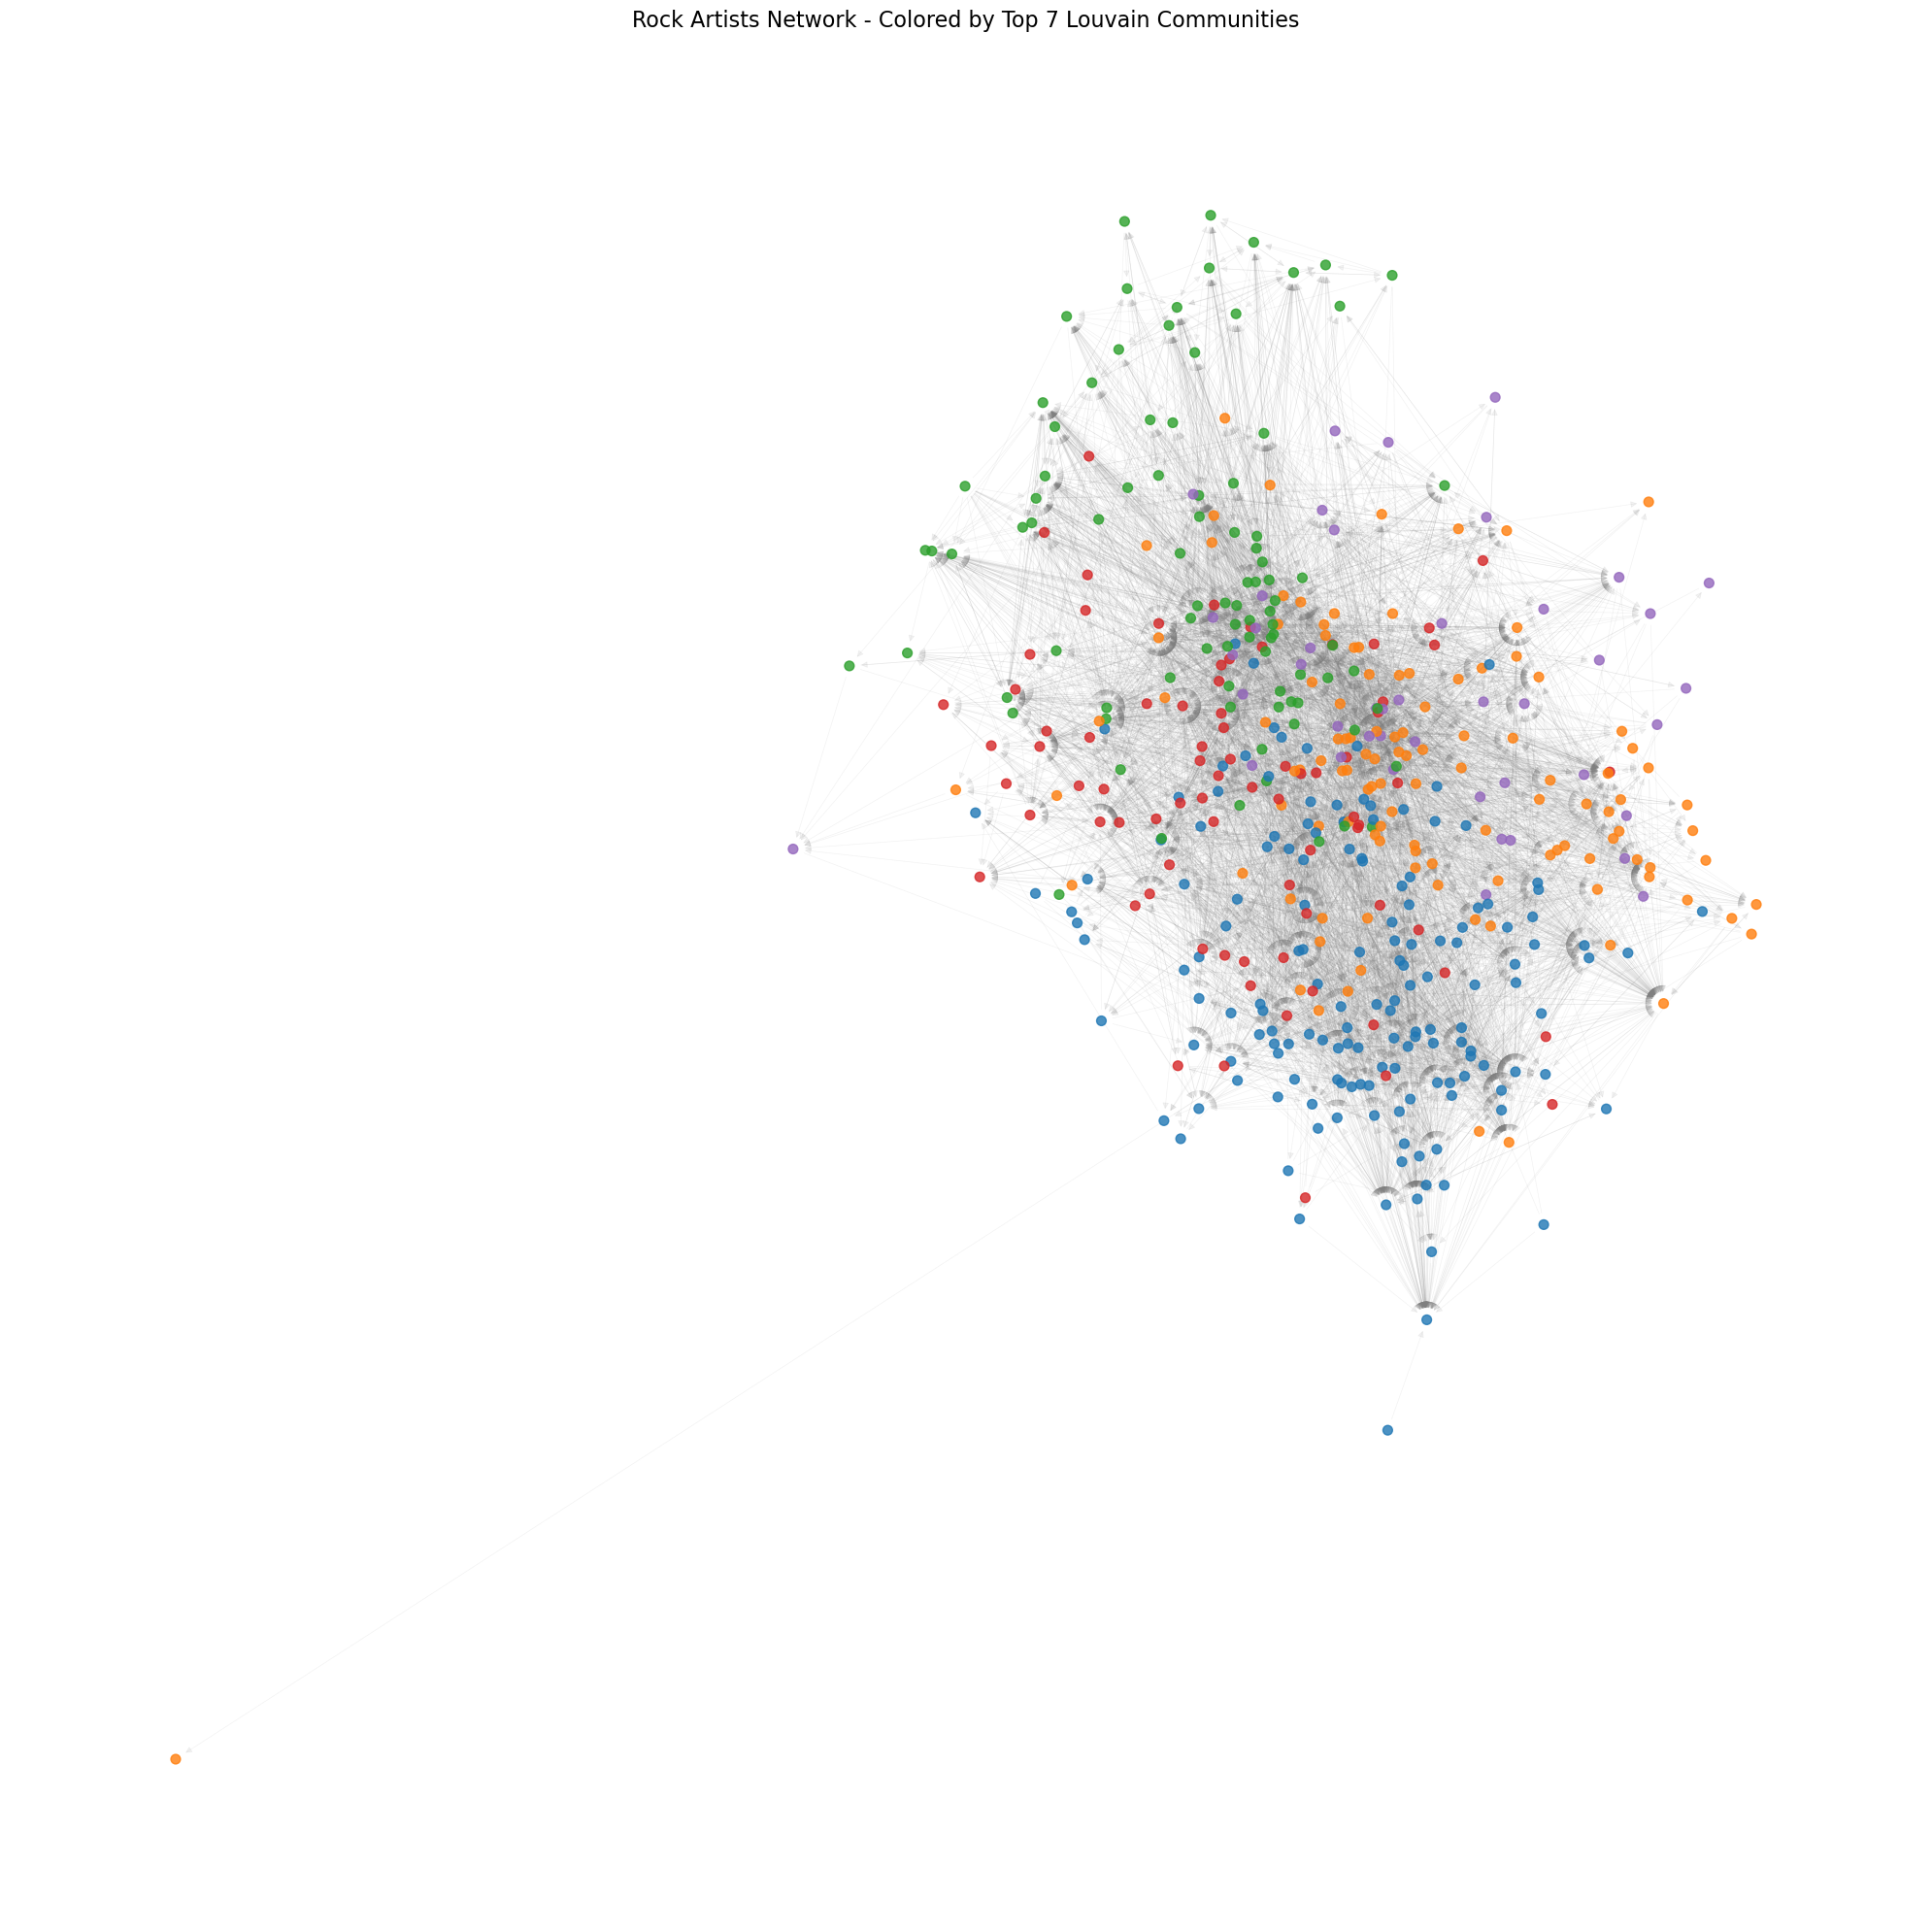

In [112]:
import matplotlib.pyplot as plt

# First, get the Louvain communities
louvain_communities = list(nx.community.louvain_communities(rock_artists_graph_filtered))

# Sort communities by size (largest first)
louvain_communities_sorted = sorted(louvain_communities, key=len, reverse=True)

# Create a dictionary mapping nodes to their community index
node_to_community = {}
for idx, community in enumerate(louvain_communities_sorted):
    for node in community:
        node_to_community[node] = idx

print(f"Found {len(louvain_communities_sorted)} communities")
print(f"Top 10 community sizes: {[len(c) for c in louvain_communities_sorted[:10]]}")

# Assign colors: top 7 communities get distinct colors, rest are gray
num_colored_communities = 7
colors = []
cmap = plt.colormaps.get_cmap('tab10')

for node in rock_artists_graph_filtered.nodes():
    comm_idx = node_to_community[node]
    if comm_idx < num_colored_communities:
        colors.append(cmap(comm_idx))
    else:
        colors.append('lightgray')
    pos = nx.forceatlas2_layout(rock_artists_graph_filtered, seed=42)


# Create visualization
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(rock_artists_graph_filtered, pos, 
                       node_color=colors, 
                       node_size=50,
                       alpha=0.8)
nx.draw_networkx_edges(rock_artists_graph_filtered, pos, 
                       alpha=0.1, 
                       width=0.5,
                       edge_color='gray')

plt.title(f"Rock Artists Network - Colored by Top {num_colored_communities} Louvain Communities", 
          fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


Ok, now in this final community exercise, we want to check if the genres align with the communities.


> *Exercise*: Communities versus genres.
> * Compare the communities found by your algorithm with the music genres by creating a matrix $D$ with dimension ($G \times C$), where G is the 7 most common genres and C is the 7 most common communities. We set entry $D(i,j)$ to be the number of nodes that genre $i$ has in common with community $j$. The matrix $D$ is what we call a confusion matrix.
> * Use the confusion matrix to explain how well the communities you've detected correspond to the genres.
>     * **Note**: This time, use all the genres associate with each node
>     * **Note**: If a node is not characterized by any of the 7 most popular genres, just ignore it.
>     * **Note**: If a node is not part of by any of the 7 largest communiteis, just ignore it.

<div class="alert alert-block alert-info">
Again, you may use an LLM to help with the code for this assignment. The main thing is you get the D matrix right and interpret it.
</div>

In [114]:
rock_artists_graph_communities_bygenre_list_sorted = sorted(rock_artists_graph_communities_bygenre_list, key=len, reverse=True)
top_7_genres = []
for community in rock_artists_graph_communities_bygenre_list_sorted[:7]:
    representative_node = next(iter(community))
    genre = rock_artists_graph_filtered.nodes[representative_node]['communities']
    top_7_genres.append(genre)

In [115]:
top_7_genres

['Rock music',
 'Alternative rock',
 'Hard rock',
 'Pop rock',
 'Heavy metal music',
 'Progressive rock',
 'Rock and roll']

In [116]:
confusion_matrix = np.zeros((7, 7), dtype=int)

for community in louvain_communities_sorted:
    comm_idx = louvain_communities_sorted.index(community)
    if comm_idx >= 7:
        for node in community:
            genre = rock_artists_graph_filtered.nodes[node]['communities']
            if genre in top_7_genres:
                genre_idx = top_7_genres.index(genre)
                confusion_matrix[comm_idx, genre_idx ] += 1




In [113]:
louvain_communities_sorted

[{'10cc',
  'ABBA',
  'Air Supply',
  'Ambrosia (band)',
  'America (band)',
  'Bachman–Turner Overdrive',
  'Badfinger',
  'Barenaked Ladies',
  'Bee Gees',
  'Bill Haley & His Comets',
  'Billy Joel',
  'Blues Traveler',
  'Bo Diddley',
  'Bob Dylan',
  'Bob Seger',
  'Bread (band)',
  'Bruce Springsteen',
  'Bryan Adams',
  'Buddy Holly',
  'Canned Heat',
  'Chicago (band)',
  'Chris Rea',
  'Chris de Burgh',
  'Christopher Cross',
  'Chubby Checker',
  'Chuck Berry',
  'Cold Chisel',
  'Counting Crows',
  'Cream (band)',
  'Creedence Clearwater Revival',
  'Crosby, Stills, Nash & Young',
  'Crowded House',
  'Dan Fogelberg',
  'Dave Matthews Band',
  'Dire Straits',
  'Don Henley',
  'Donovan',
  'Duane Eddy',
  'Eagles (band)',
  'Eddie Cochran',
  'Eddie Money',
  'Electric Light Orchestra',
  'Elton John',
  'Elvis Costello',
  'Elvis Presley',
  'England Dan & John Ford Coley',
  'Eric Clapton',
  'Everlast',
  'Fats Domino',
  'Fleetwood Mac',
  'Frank Zappa',
  'Gene Vincent'

# Part 3: Words that characterize pages or groups of pages

Now, we'll begin to play around with how far we can get with simple strategies for looking at text. 

The video is basically just me talking about a fun paper, which shows you how little is needed in order to reveal something highly interesting about humans that produce text. But it's important. Don't miss this one!

> **Video lecture**: Simple methods reveal a lot. I talk about the paper: [Personality, Gender, and Age in the Language of Social Media: The Open-Vocabulary Approach](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073791).  

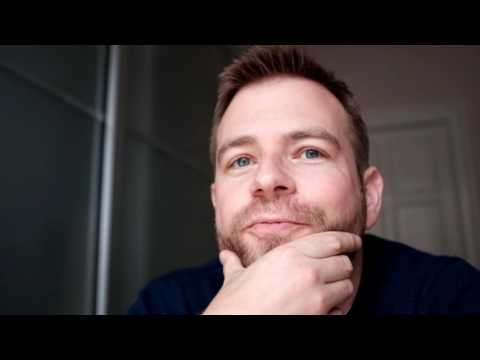

In [3]:
YouTubeVideo("wkYvdfkVmlI",width=800, height=450)

# direct youtube link: https://www.youtube.com/watch?v=wkYvdfkVmlI

_Exercise_: Comparing in the different genres. 

*Setup*. You'll need to go to your archives and find the wikipedia pages of all the rock artists. 

Once you have the texts ready, you will want to aggregate the text into 15 long lists, one for each of the top 15 genres (let's call them 15 *documents*). Each document contains on all the text in that genre (so for the rock genre it's a looooong big doc). In each list, you should keep all the words (or *tokens* to be more precise) that occur on the pages, and a count of how frequently each word occurs. So the format should be

```
word0 count0
word1 count1
word2 count2

...

wordN countN
```
This list is called a ***Term Frequency*** (or TF) list for each genre. Let's build our own TF lists. Before you start counting, I am going to ask you do do a few things

> *Action items*
> * Tokenize the pages into one long string per genre
> * Remove all punctuation from your list of tokens
> * Set everything to lower case
> * (Optional) Lemmatize your words
> * It's a good idea to filter out rare words (e.g. words that only appear less than 5 times).

If you are confused by the instructions for cleaning, go back and have a look at Chapter 3 again. You need to use the tools from the book to clean the text.

> *Action item*: 
> * Create your TF list for each of the 15 most popular genres.
> * List the top 15 words for each genre.
> * Comment on the top 15 words for each genre.

**Note**: Above you (once again) have to deal with the fact that many artists have multiple genres listed. Pick the method you like the best to deal with this. Some possible choices
* Counting each page multiple times, so a page counts once per genre that's listed
* Picking the first genre listed
* Picking the second genre listed
* Picking a random genre
* (... any other heuristic you like, e.g. using an api to ask an LLM to pick the genre that best describes the page from its list)

<div class="alert alert-block alert-info">
It's OK to use an LLM to help with the code here, but write your own comments.
</div>

# Part 4: Visualization

**Step 1: Install the software**

First you must set up your system. The most difficult thing about creating the wordcloud is installing the `WordCloud` module. It's available on GitHub, check out the page [**here**](https://github.com/amueller/word_cloud). 

You should be able to simply install using conda (and all dependencies, etc will be automatically fixed): 

    conda install -c conda-forge wordcloud
 
If you can't get that to work, there is more info on the GitHub page
 * On my system, the module needed the `gcc` compiler installed. If you're not already a programmer, you may have to install that. On Mac you get it by installing the [_command line tools_](http://osxdaily.com/2014/02/12/install-command-line-tools-mac-os-x/). On linux, it's probably already installed. And on Windows I'm not sure, but we'll figure it out during the exercises. 
 * Once that's all set up, you can use `pip` to install the `WordCloud` library, as [detailed on the GitHub page](https://github.com/amueller/word_cloud). But don't forget to use Anaconda's `pip`.
 * There are examples of how to use the module online, see [this page](http://sebastianraschka.com/Articles/2014_twitter_wordcloud.html) for a nice example. If you're interested, you can read about how the package was put together - and how it works [here](http://peekaboo-vision.blogspot.dk/2012/11/a-wordcloud-in-python.html). 

**Step 2: Draw some wordclouds**

> *Action items*
> * Get your lists ready for the word-cloud software
>    - The package needs a single string to work on. The way that I converted my lists to a string was to simply combine all words together in one long string (separated by spaces), repeating each word according to its count. 
>    - The `wordcloud` package looks for collocations in real texts, which is a problem when you make the list as above. The recommended fix is to simply set `collocations = False` as an option when you run the package.
> * Now, create a word-cloud for each genre. Feel free to make it as fancy or non-fancy as you like. Comment on the results. (If you'd like, you can remove stopwords and wiki-syntax - I did a bit of that for my own wordclouds.)

<div class="alert alert-block alert-info">
As above, it's OK to use an LLM to help get the code going. But write your own answers to the questions.
</div>

# Part 5: Understanding TF-IDF

Now we jump back into the NLP work. In this last part, we'll be creating word-clouds again. But this time, we'll be using the method from the paper I discuss above: TF-IDF. Historically people have had a hard time grasping the idea behind TF-IDF, so here's a little exercise designed to make you study it a bit more carefully.

*Exercise 4*: Wrap your brain around TF-IDF

First, let's learn about TF-IDF the way wikipedia explains it. Check out [the wikipedia page for TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) and ***read the first part very carefully***. The idea is that the term frequency doesn't capture just what's special about a text. It also only captures words that are just frequent in all text. 

This is clear from the top counts in one of my lists:

```
of 
in 
and 
the 
to 
a 
is
by
was
as
ref
with
first
 ```
 
You can fix some of this by removing stop-words (as is described in the book), but it's not enough. ***We want to pull out what's special about a particular text.*** 

To focus on just what's special, TF-IDF has two components: The *term frequency* (TF) and a *weight* (IDF). The weight draws on a larger corpus of text emphasize what's special about the text we're interested in.

Further, there are some extra things going on. For example, there are multiple definitions of TF on wikipedia. Above, we just looked at the raw counts.

> *Action item*
>   * Pick one of the alternative term frequency definitions. Explain why it might sometimes be prefereable to the raw count.

Now, let's talk about the inverse document frequency.

> *Action item*
>   * What does IDF stand for? Answer in your own words.
>   * How does IDF draw on a larger corpus to extract what's special a certain text? Answer in your own words.

There are also multiple versions of IDF. Let's think about those for a moment.

> *Action items*
>   * All of the IDF versions take the log of the calculated weight. Why do you think that is?
>   * Explain why using IDF makes stopword removal less important.

<div class="alert alert-block alert-info">
The point of this exercise is to understand TF-IDF. So if there are parts of the wikipedia page you don't understand, I encourage you to ask questions to an LLM to really understand the concept. Perhaps ask it to explain TF-IDF at the level of a high-school student. Once you've done that, then answer the questions in the action items on your own.
</div>

# Part 6: Genres and TF-IDF word-clouds

**But wait a minute!** Now we have all of the ingredients for a wonderful cocktail 😎

* We have genres - descriptions of related nodes in the network. 
* And you're an expert on TF-IDF, so you can extract words that characterize a text relative to everything that's going on.
* Finally, you can create nice WordCouds!

So let's put it all together. Let's use TF-IDF and wordcoulds to build a deeper understanding of the top communities.

Thus, the aim of this final part is to create genre wordclouds for the top 15 genres based on TF-IDF. 

For each genre, create a single document for each community consisting of all the cleaned text from all members of the community. So in the end, you should have 15 documents in total.

_Exercise_: Genre Word-clouds

> * Now that we have the community-texts, let's start by grabbing the TF lists from the exercise above (you may modify to use whichever version of TF you like). 
> * Next, calculate IDF for every word in every list (use whichever version of IDF you like). 
>   * Which base logarithm did you use? Is that important?
> * We're now ready to calculate TF-IDFs. Do that for each genre. 
>   * List the 10 top words for each genre accourding to TF-IDF. Are these 10 words more descriptive of the genre than just the TF? Justify your answer.
> * Create a wordcloud for each genre.
>     * **Note**: you may have to rescale the TF-IDF weights so they make sense to the wordcloud package. Write about this issue and how you solve it.
> * Explain your creation. Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

<div class="alert alert-block alert-info">
Overall, it's OK to use an LLM to help with the code. But do write your own answers to the questions.
</div>

*Exercise*: Community Word-clouds
> * Redo the exercise above but for the 15 largest structural communities.
> * Do the word clouds seem more meaningful than for the genres? Optional: Add nuance to your answer by considering the confusion matrix $D$ that you calculated above.

Note that this is a great way of characterizing the structural communities if you don't have genre-labels (or other labels for that matter).

<div class="alert alert-block alert-info">
Todays exercices are getting, long and involved so you can do whatever parts of this one that you like with LLMs. Maybe you can even get one to solve the whole exercise?
</div>